In [2]:
# General
import os
from os.path import join

# Data wrangling
import pandas as pd
from objects import Dataset, Clustering

In [4]:
CURRENT_DIR = os.getcwd()
balanced_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'balanced_df.pkl'))
enzyme_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'enzyme_df_sequences.pkl'))

In [11]:
data = Dataset(balanced_df)
featurised = data.featurise_df('substrate', 'fingerprint')

In [38]:
enzyme_dfs = {}
for i in range (1,8):
    enzyme_dfs[i] = balanced_df[balanced_df['ec_number'].str.startswith(str(i))]
    enzyme_dfs[i] = Dataset(enzyme_dfs[i])
    enzyme_dfs[i] = enzyme_dfs[i].featurise_df('substrate', 'fingerprint')

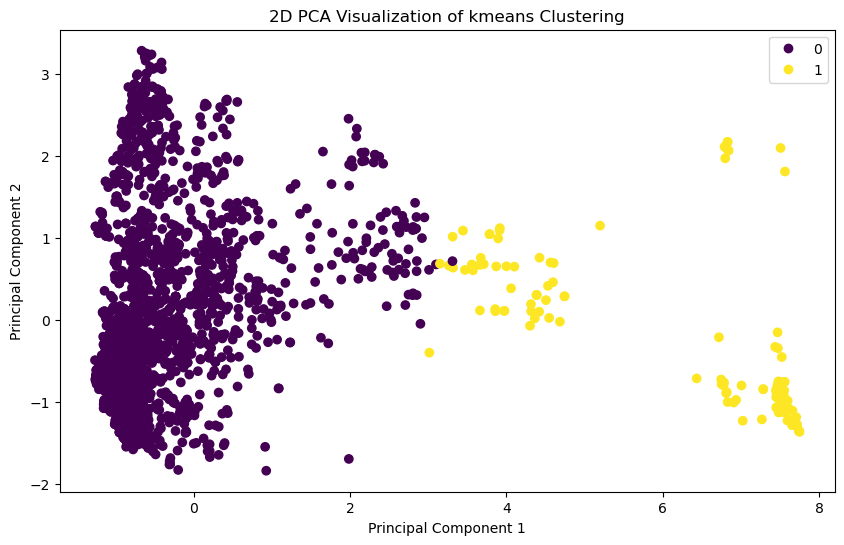

{'Silhouette Score': 0.2840663474507463,
 'Davies-Bouldin Score': 1.4184750083902475}

In [39]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[1])
clustering.visualise(enzyme_dfs[1])
clustering.evaluate(enzyme_dfs[1])

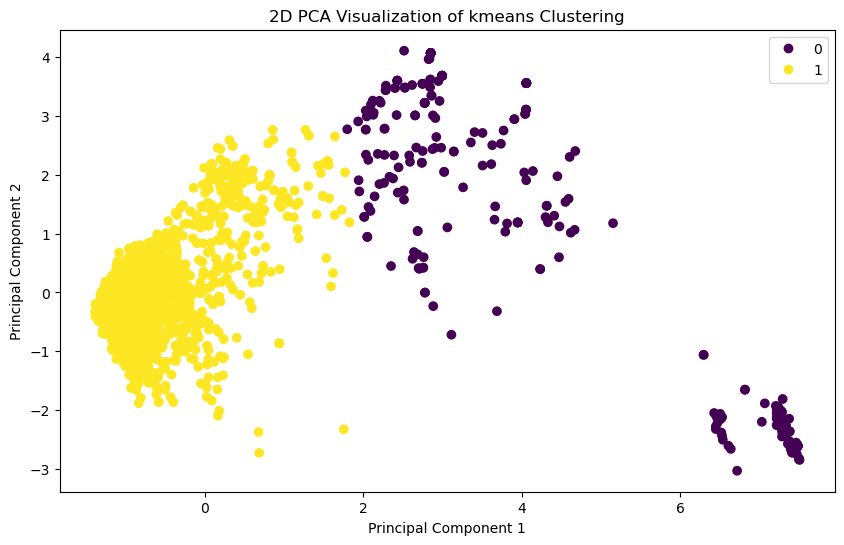

{'Silhouette Score': 0.2351510227545466,
 'Davies-Bouldin Score': 1.968978686060568}

In [40]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[2])
clustering.visualise(enzyme_dfs[2])
clustering.evaluate(enzyme_dfs[2])

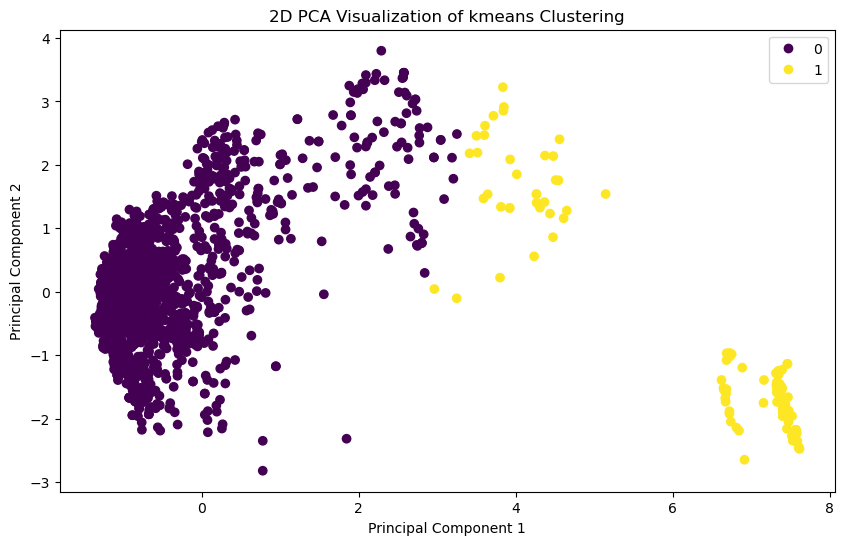

{'Silhouette Score': 0.2752106436660032,
 'Davies-Bouldin Score': 1.4390945247709568}

In [41]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[3])
clustering.visualise(enzyme_dfs[3])
clustering.evaluate(enzyme_dfs[3])

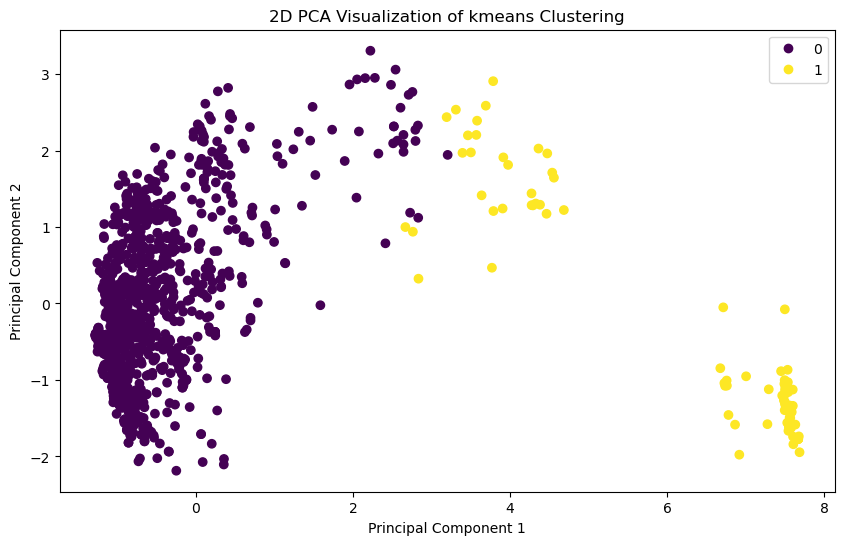

{'Silhouette Score': 0.2801661062124054,
 'Davies-Bouldin Score': 1.444356171891581}

In [42]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[4])
clustering.visualise(enzyme_dfs[4])
clustering.evaluate(enzyme_dfs[4])

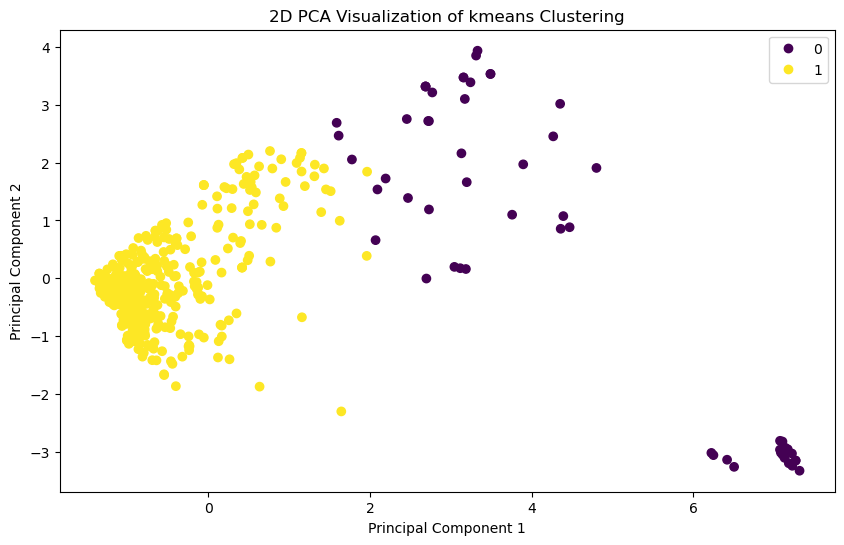

{'Silhouette Score': 0.23247252856597578,
 'Davies-Bouldin Score': 2.1287700370873015}

In [43]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[5])
clustering.visualise(enzyme_dfs[5])
clustering.evaluate(enzyme_dfs[5])

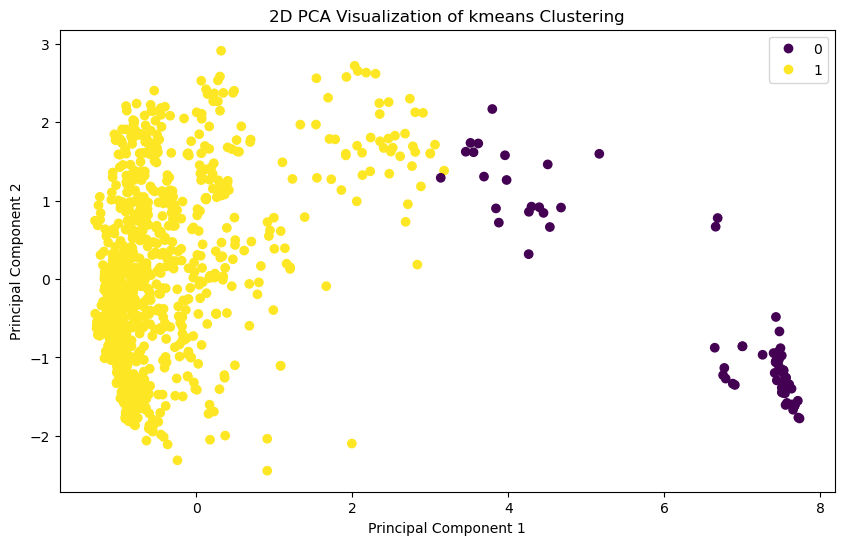

{'Silhouette Score': 0.276229189526931,
 'Davies-Bouldin Score': 1.3739304310155247}

In [44]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[6])
clustering.visualise(enzyme_dfs[6])
clustering.evaluate(enzyme_dfs[6])

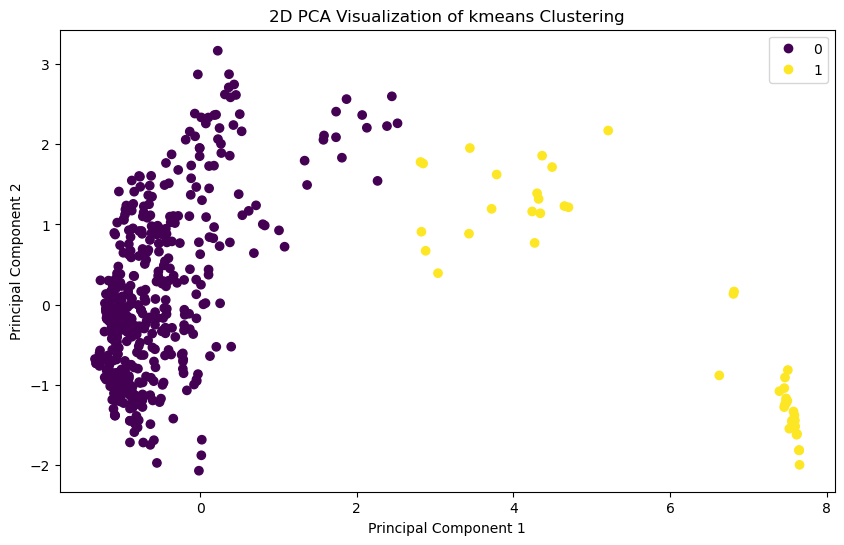

{'Silhouette Score': 0.2833362604446001,
 'Davies-Bouldin Score': 1.4913113802527884}

In [45]:
clustering = Clustering(method = 'kmeans', n_clusters = 2)
clustering.cluster(enzyme_dfs[7])
clustering.visualise(enzyme_dfs[7])
clustering.evaluate(enzyme_dfs[7])

### Analysis of False Negatives

In [12]:
wrongly_classified_df = pd.read_pickle(join(CURRENT_DIR, '..' , 'Data', 'Dataframes', 'wrongly_classified_df.pkl'))
false_negs_df = wrongly_classified_df[(wrongly_classified_df['true_label'] == 1) & (wrongly_classified_df['predicted_label'] == 0)]

In [14]:
false_negs_df

,enzyme,ec_number,ESM1b,substrate,smiles,fingerprint,ESM2,true_label,ESM1b_fingerprint_Combined,predicted_label
23,3-oxoacyl-[acyl-carrier-protein] reductase,1.1.1.100,"[0.06207834184169769, 0.10712146013975143, -0....",acetoacetyl-CoA,CC(=O)CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04713781177997589, -0.06532732397317886, 0....",1,"[0.06207834184169769, 0.10712146013975143, -0....",0
64,Galactose 1-dehydrogenase (nadp+),1.1.1.120,"[-0.006036235019564629, 0.24389895796775818, -...",beta-D-galactose,C(C1C(C(C(C(O1)O)O)O)O)O,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03720759600400925, 0.06572382897138596, -0...",1,"[-0.006036235019564629, 0.24389895796775818, -...",0
79,2-deoxy-d-gluconate 3-dehydrogenase,1.1.1.125,"[0.015054035931825638, 0.1089935451745987, -0....",2-deoxy-D-gluconate,C(C(C(C(CO)O)O)O)C(=O)O,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07612820714712143, -0.06758210808038712, -...",1,"[0.015054035931825638, 0.1089935451745987, -0....",0
97,Dtdp-4-dehydrorhamnose reductase,1.1.1.133,"[0.11528757959604263, 0.09311238676309586, 0.0...",dTDP-4-dehydro-beta-L-rhamnose,CC1C(=O)C(C(C(O1)OP(=O)(O)OP(=O)(O)OCC2C(CC(O2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01571831665933132, -0.17687542736530304, -0...",1,"[0.11528757959604263, 0.09311238676309586, 0.0...",0
99,Dtdp-4-dehydrorhamnose reductase,1.1.1.133,"[0.11528757959604263, 0.09311238676309586, 0.0...",dTDP-6-deoxy-L-mannose,CC1C(C(C(C(O1)OP(=O)(O)OP(=O)(O)OCC2C(CC(O2)N3...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.01571831665933132, -0.17687542736530304, -0...",1,"[0.11528757959604263, 0.09311238676309586, 0.0...",0
...,...,...,...,...,...,...,...,...,...,...
10178,"Hydrogenobyrinic acid a,c-diamide synthase (gl...",6.3.5.9,"[0.04946070536971092, 0.19843319058418274, -0....",L-glutamine,C(CC(=O)N)C(C(=O)O)N,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.04207907244563103, -0.09506884962320328, 0....",1,"[0.04946070536971092, 0.19843319058418274, -0....",0
10185,Acetyl-coa carboxylase,6.4.1.2,"[0.07392029464244843, -0.005136899184435606, -...",propionyl-CoA,CCC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04508853703737259, -0.14279215037822723, 0...",1,"[0.07392029464244843, -0.005136899184435606, -...",0
10187,Acetyl-coa carboxylase,6.4.1.2,"[0.07392029464244843, -0.005136899184435606, -...",butyryl-CoA,CCCC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.04508853703737259, -0.14279215037822723, 0...",1,"[0.07392029464244843, -0.005136899184435606, -...",0
10272,Na+/k+-exchanging atpase,7.2.2.13,"[0.026333769783377647, 0.3588842749595642, 0.0...",Na,[Na],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.05448728799819946, -0.02164268121123314, 0...",1,"[0.026333769783377647, 0.3588842749595642, 0.0...",0


### Analysis of False Positives

In [15]:
false_pos_df = wrongly_classified_df[(wrongly_classified_df['true_label'] == 0) & (wrongly_classified_df['predicted_label'] == 1)]

In [16]:
false_pos_df

,enzyme,ec_number,ESM1b,substrate,smiles,fingerprint,ESM2,true_label,ESM1b_fingerprint_Combined,predicted_label
10599,Galactose 1-dehydrogenase (nadp+),1.1.1.120,"[-0.006036235019564629, 0.24389895796775818, -...",H,[HH],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03720759600400925, 0.06572382897138596, -0...",0,"[-0.006036235019564629, 0.24389895796775818, -...",1
10991,Mannitol-1-phosphate 5-dehydrogenase,1.1.1.17,"[0.03953283280134201, 0.09652134031057358, 0.0...",adenosine,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)CO)O)O)N,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024463588371872902, -0.09442353248596191, 0...",0,"[0.03953283280134201, 0.09652134031057358, 0.0...",1
10997,Mannitol-1-phosphate 5-dehydrogenase,1.1.1.17,"[0.03953283280134201, 0.09652134031057358, 0.0...",Smo,O.O.[SH-].[Mo],"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.024463588371872902, -0.09442353248596191, 0...",0,"[0.03953283280134201, 0.09652134031057358, 0.0...",1
11358,7beta-hydroxysteroid dehydrogenase (nadp+),1.1.1.201,"[0.08879625797271729, 0.18706351518630981, -0....",S-adenosyl-L-methionine,C[S+](CCC(C(=O)[O-])N)CC1C(C(C(O1)N2C=NC3=C(N=...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.011631532572209835, 0.020034184679389, -0.0...",0,"[0.08879625797271729, 0.18706351518630981, -0....",1
11884,Glyoxylate reductase,1.1.1.26,"[0.014485963620245457, 0.25010788440704346, -0...",acetyl-CoA,CC(=O)SCCNC(=O)CCNC(=O)C(C(C)(C)COP(=O)(O)OP(=...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.006874608341604471, -0.0007444860530085862...",0,"[0.014485963620245457, 0.25010788440704346, -0...",1
...,...,...,...,...,...,...,...,...,...,...
39056,Cystathionine gamma-lyase,4.4.1.1,"[0.030275747179985046, 0.3991106450557709, 0.0...",L-homocysteine,C(CS)C(C(=O)O)N,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.027709366753697395, -0.10196924954652786, -...",0,"[0.030275747179985046, 0.3991106450557709, 0.0...",1
39332,Udp-glucose 4-epimerase,5.1.3.2,"[-0.0747973769903183, 0.20874299108982086, 0.1...",ADP-ribose,C1=NC(=C2C(=N1)N(C=N2)C3C(C(C(O3)COP(=O)(O)OP(...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.005540673155337572, -0.12142900377511978, ...",0,"[-0.0747973769903183, 0.20874299108982086, 0.1...",1
39478,Phosphogalactosamine mutase,5.4.2.13,"[0.02094169519841671, 0.18777480721473694, 0.0...",4-aminobutyrate,C(CC(=O)O)CN,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.08027300238609314, -0.05081900209188461, 0....",0,"[0.02094169519841671, 0.18777480721473694, 0.0...",1
39874,4-coumarate-coa ligase,6.2.1.12,"[0.1201624646782875, 0.1128171756863594, 0.115...",ITP,C1=NC2=C(C(=O)N1)N=CN2C3C(C(C(O3)COP(=O)(O)OP(...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0009492618264630437, -0.08171805739402771, ...",0,"[0.1201624646782875, 0.1128171756863594, 0.115...",1
